#Data Understanding and Visualizations.


##1. Import Required Libraries

In [30]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


##2. Dataset Preparation

###2.1 Verify Dataset Structure

In [13]:
# Define paths and parameters
train_dir = "/content/drive/MyDrive/AI and ML/Week 5/FruitinAmazon/FruitinAmazon/train"  # Replace with your dataset path
image_size = (28, 28)  # Input image size
batch_size = 32

# Get class names
class_names = sorted(os.listdir(train_dir))
if not class_names:
    print("No class directories found in the train folder!")
else:
    print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


###2.2 Check for Corrupted Images


In [14]:
from PIL import Image, UnidentifiedImageError

corrupted_images = []  # List to store corrupted image paths

# Loop through each class folder and check for corrupted images
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it’s a valid directory
        images = os.listdir(class_path)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify image integrity
            except (IOError, UnidentifiedImageError):
                corrupted_images.append(img_path)

# Print results
if corrupted_images:
    print("\nCorrupted Images Found:")
    for img in corrupted_images:
        print(img)
else:
    print("\nNo corrupted images found.")


No corrupted images found.


###2.3 Count Class Balance


In [15]:
# Dictionary to store class counts
class_counts = {}

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images)  # Count images in each class

# Print class balance
print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")
print("=" * 45)


Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


###2.4 Select Random Images for Visualization


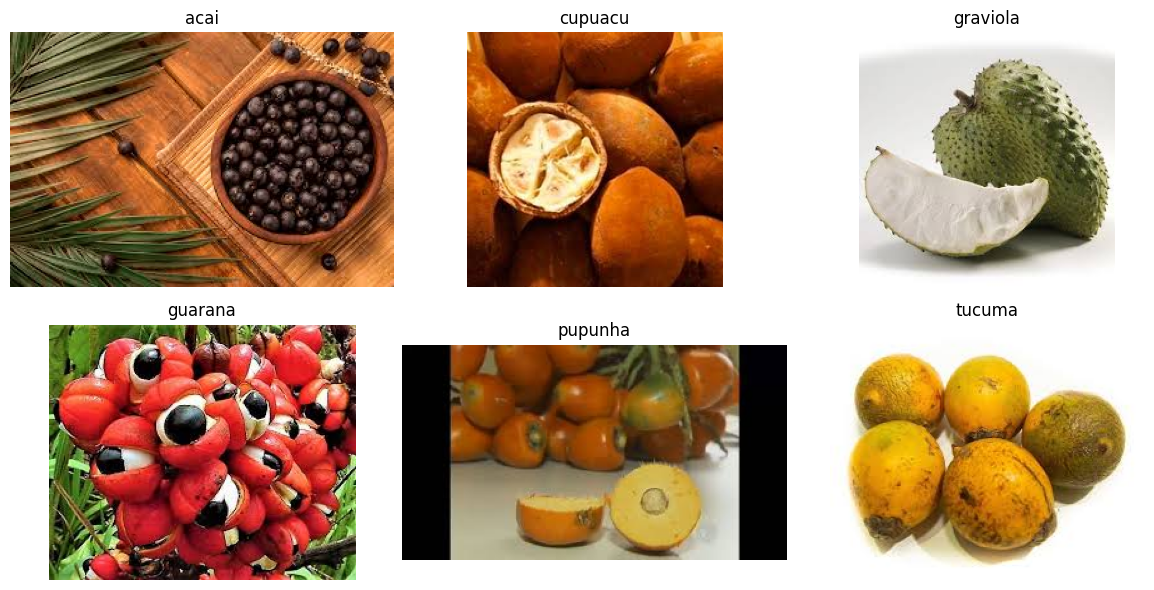

In [16]:
import random

selected_images = []  # Store image paths
selected_labels = []  # Store corresponding class names

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:  # Ensure the class folder is not empty
            selected_img = os.path.join(class_path, random.choice(images))
            selected_images.append(selected_img)
            selected_labels.append(class_name)

# Display randomly selected images in a grid format
num_classes = len(selected_images)
cols = (num_classes + 1) // 2  # Determine columns
rows = 2  # Fixed rows for layout

fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < num_classes:
        img = plt.imread(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i])
        ax.axis("off")
    else:
        ax.axis("off")  # Hide empty subplots
plt.tight_layout()
plt.show()

##3. Data Generation and Preprocessing

###3.1 Generate Train and Validation Datasets


In [32]:
image_size = (28, 28)
batch_size = 32

train_ds, val_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Using 18 files for validation.


###3.2 Visualize Training Dataset


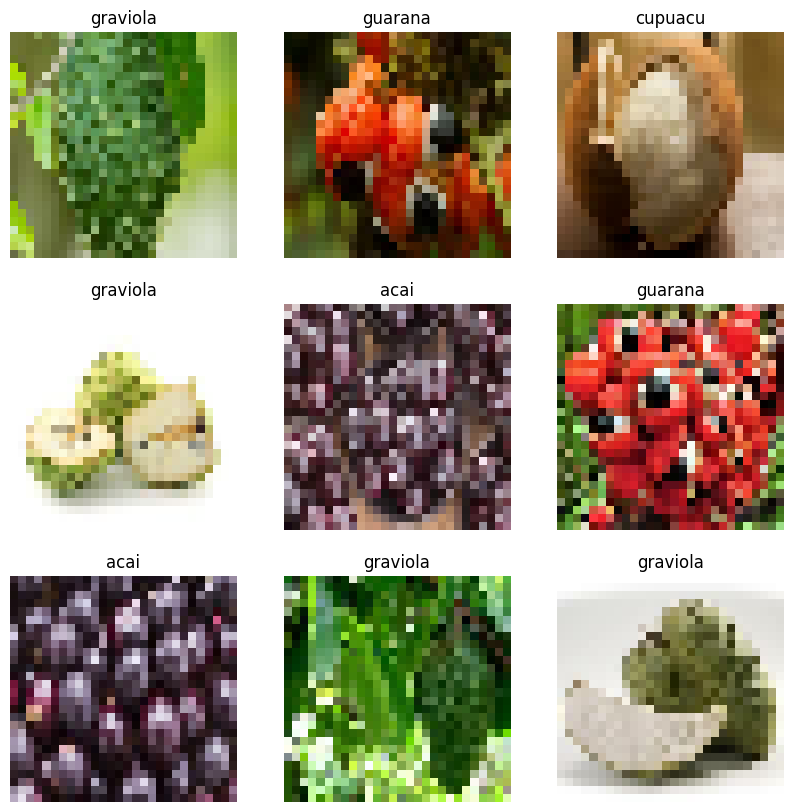

In [35]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

###3.3 Data Augmentation


In [36]:
# Generate train and validation datasets
image_size = (28, 28)
batch_size = 32
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# Define the data augmentation layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

# Update the data_augmentation function
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)  # Apply each augmentation layer
    return images

# Apply data augmentation and rescaling
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
augmented_train_ds = augmented_train_ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y))
val_ds = val_ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Using 18 files for validation.


##4. Model Building


###4.1 Define the CNN Model


In [43]:
from tensorflow.keras import Sequential, layers

# Define the CNN model
model = Sequential([
    # Input layer with Rescaling already applied in the dataset pipeline
    layers.Input(shape=(28, 28, 3)),  # Adjust input shape based on your dataset (e.g., 3 channels for RGB)

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten the output of the last Conv2D layer
    layers.Flatten(),

    # First Fully Connected Layer
    layers.Dense(512, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    # Second Fully Connected Layer
    layers.Dense(256, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    # Output Layer
    layers.Dense(len(class_names), activation='softmax')  # Use softmax for multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam',  # Adam optimizer for adaptive learning rates
    loss='sparse_categorical_crossentropy',  # Sparse categorical crossentropy for integer labels
    metrics=['accuracy']  # Track accuracy during training
)

# Print the model summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_25 (Activation)           │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_26 (Activation)           │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_27 (Activation)           │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_28 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 820,422 (3.13 MB)

 Trainable params: 818,438 (3.12 MB)

 Non-trainable params: 1,984 (7.75 KB)

##5. Training the Model


###5.1 Add Callbacks


In [24]:
# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=5,                  # Wait for 5 epochs before stopping
    restore_best_weights=True    # Restore weights from the best epoch
)

# Define Learning Rate Reduction on Plateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Monitor validation loss
    factor=0.2,                  # Reduce learning rate by a factor of 0.2
    patience=3,                  # Wait for 3 epochs before reducing LR
    min_lr=1e-6                  # Minimum learning rate
)

##5.2 Train the Model


In [39]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 352ms/step - accuracy: 0.1102 - loss: 2.3935 - val_accuracy: 0.0556 - val_loss: 1.7988 - learning_rate: 0.0010
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.1311 - loss: 2.2409 - val_accuracy: 0.1667 - val_loss: 1.8014 - learning_rate: 0.0010
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.2335 - loss: 2.1341 - val_accuracy: 0.1667 - val_loss: 1.8130 - learning_rate: 0.0010
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step - accuracy: 0.2826 - loss: 1.8571 - val_accuracy: 0.1667 - val_loss: 1.8414 - learning_rate: 0.0010
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.3720 - loss: 1.6977 - val_accuracy: 0.1667 - val_loss: 1.8435 - learning_rate: 2.0000e-04
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.5165 - loss: 1.4174 - val_accuracy: 0.1667 - val_loss: 1.8416 - learning_rate: 2.0000e-04


##6. Evaluate the Model


##6.1 Plot Training History


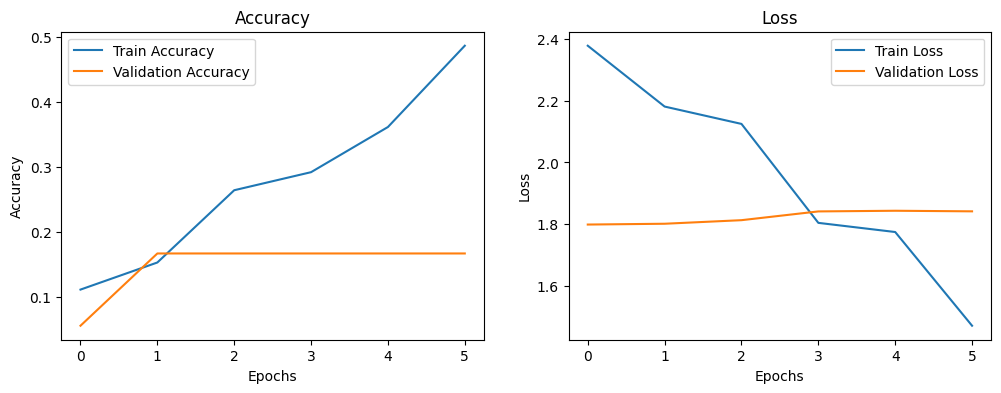

In [40]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

##6.2 Evaluate on Validation Dataset


In [41]:
# Evaluate the model
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test Accuracy: {test_acc:.4f}")

# Extract all true labels from the validation dataset
true_labels = [label.numpy() for _, label in val_ds.unbatch()]  # Collect labels as a list
true_labels = np.array(true_labels)  # Convert the list to a NumPy array

# Generate predictions
predictions = model.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Print some predictions
for i in range(5):  # Print predictions for the first 5 samples
    print(f"Predicted: {class_names[predicted_labels[i]]}, Actual: {class_names[true_labels[i]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.0556 - loss: 1.7988
Test Accuracy: 0.0556
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted: guarana, Actual: pupunha
Predicted: guarana, Actual: pupunha
Predicted: guarana, Actual: cupuacu
Predicted: guarana, Actual: tucuma
Predicted: guarana, Actual: cupuacu


Try not to use batch normalization.
use sgd instead maybe